# 01 — Multi-Venue Data Acquisition & Processing

**Objective:** Download, clean, and align BTC perpetual futures trade data from multiple venues for cross-venue microstructure analysis.

**Venues:**
- **Binance** — BTCUSDT Perpetual Futures
- **Bybit** — BTCUSDT Perpetual Futures

**Date range:** 2026-01-30 to 2026-02-05 (7 days)

**Pipeline (applied to each venue):**
1. Download daily trade data from public bulk-download endpoints
2. Load and standardise column names
3. Align timestamps to UTC with millisecond precision
4. Classify trade sides (buy/sell)
5. Compute derived fields: log returns, inter-trade durations
6. Run quality checks
7. Visualise key distributions
8. Save processed data to Parquet format

### Data source availability note

We investigated four additional venues but were unable to obtain trade-level data for our target date range:

- **OKX** — Bulk CDN archives (`allfuture-trades-YYYY-MM-DD.zip`) are published with a ~6-month delay; data only available up to August 2025. The REST API (`/api/v5/market/history-trades`) returns only 100 trades per request with no timestamp filter, making historical retrieval impractical.
- **Coinbase** (BTC-USD Spot) — No bulk download available. REST API returns 1,000 trades per page at ~1,500 trades/sec effective rate; covering 8+ days requires ~55 minutes of continuous pagination, which exceeded notebook execution timeouts.
- **Gate.io** — No bulk download available. REST API returns 1,000 trades per page at ~526 trades/sec; covering 9 days would require ~5 hours.

All three venues have working download functions in `src/data.py` (OKX, Coinbase) and could be used when bulk archives become available or for shorter time windows. The download functions are retained for future use.

**For the core analysis (cross-venue transfer entropy), Binance + Bybit provides a strong two-venue comparison** — both are major BTCUSDT perpetual futures venues with different trader populations and latency profiles, giving us meaningful directional information flow to measure.

In [1]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path

from src.data import (
    download_binance_trades,
    download_bybit_trades,
    load_raw_trades,
    standardise_columns,
    align_timestamps,
    classify_trade_side,
    compute_derived_fields,
    run_quality_checks,
    save_processed,
)
from src.visualisation import set_style, VENUE_COLOURS, plot_price_overlay

set_style()

# Date range — same 7-day period for all venues
START_DATE = "2026-01-30"
END_DATE = "2026-02-05"

# Paths
RAW_BASE = Path("../data/raw")
PROCESSED_DIR = Path("../data/processed")

print("Setup complete.")

Setup complete.


## Helper: Processing Pipeline

A reusable function that applies the full processing pipeline to any venue's raw data: load → standardise → align → classify → derive → quality check.

In [2]:
def process_venue(csv_files, venue):
    """Load, standardise, align, classify, and derive fields for a venue."""
    dfs = []
    for f in csv_files:
        df = load_raw_trades(f, venue=venue)
        df = standardise_columns(df, venue=venue)
        dfs.append(df)

    trades = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {len(trades):,} raw trades across {len(csv_files)} days.")

    trades = align_timestamps(trades)
    print(f"Time range: {trades['timestamp'].min()} → {trades['timestamp'].max()}")

    trades = classify_trade_side(trades)
    buy_count = (trades["trade_sign"] == 1).sum()
    sell_count = (trades["trade_sign"] == -1).sum()
    print(f"Buy-initiated:  {buy_count:>12,} ({buy_count/len(trades):.1%})")
    print(f"Sell-initiated: {sell_count:>12,} ({sell_count/len(trades):.1%})")

    trades = compute_derived_fields(trades)
    print(f"Log returns — mean: {trades['log_return'].mean():.2e}, std: {trades['log_return'].std():.2e}")
    print(f"Inter-trade duration — median: {trades['inter_trade_duration_ms'].median():.1f} ms, "
          f"mean: {trades['inter_trade_duration_ms'].mean():.1f} ms")

    return trades


def plot_venue_overview(trades, venue_name):
    """Plot the standard 4-panel overview for a single venue."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # (a) Price
    price_1min = trades.set_index("timestamp")["price"].resample("1min").last().dropna()
    axes[0, 0].plot(price_1min.index, price_1min.values, linewidth=0.8)
    axes[0, 0].set_title("Price (1-min)")
    axes[0, 0].set_ylabel("Price (USDT)")

    # (b) Trade arrival rate
    arrival = trades.set_index("timestamp").resample("1min").size()
    axes[0, 1].plot(arrival.index, arrival.values, linewidth=0.5, alpha=0.7)
    axes[0, 1].set_title("Trade Arrival Rate (per minute)")
    axes[0, 1].set_ylabel("Trades / min")

    # (c) Log return distribution
    returns_clean = trades["log_return"].dropna()
    axes[1, 0].hist(returns_clean.clip(-0.001, 0.001), bins=200, edgecolor="none", alpha=0.7)
    axes[1, 0].set_title("Log Return Distribution (clipped ±0.1%)")
    axes[1, 0].set_xlabel("Log Return")
    axes[1, 0].set_ylabel("Count")

    # (d) Inter-trade duration distribution
    durations = trades["inter_trade_duration_ms"].dropna()
    axes[1, 1].hist(durations.clip(0, 500), bins=200, edgecolor="none", alpha=0.7)
    axes[1, 1].set_title("Inter-Trade Duration Distribution (clipped <500ms)")
    axes[1, 1].set_xlabel("Duration (ms)")
    axes[1, 1].set_ylabel("Count")

    for ax in axes.flat:
        ax.grid(True, alpha=0.3)

    fig.suptitle(f"{venue_name} — Data Overview", fontsize=14, y=1.01)
    fig.tight_layout()
    plt.show()


def plot_intraday(trades, venue_name):
    """Plot intraday patterns: trades per hour and average trade size."""
    hour = trades["timestamp"].dt.hour

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    hourly_counts = trades.groupby(hour).size()
    axes[0].bar(hourly_counts.index, hourly_counts.values, alpha=0.7)
    axes[0].set_title("Total Trades by Hour (UTC)")
    axes[0].set_xlabel("Hour (UTC)")
    axes[0].set_ylabel("Trade Count")

    hourly_size = trades.groupby(hour)["quantity"].mean()
    axes[1].bar(hourly_size.index, hourly_size.values, alpha=0.7, color="orange")
    axes[1].set_title("Average Trade Size by Hour (UTC)")
    axes[1].set_xlabel("Hour (UTC)")
    axes[1].set_ylabel("Avg Quantity (BTC)")

    fig.suptitle(f"{venue_name} — Intraday Patterns", fontsize=14)
    fig.tight_layout()
    plt.show()


def print_quality_report(trades, venue):
    """Run and print quality checks for a venue."""
    quality = run_quality_checks(trades, venue=venue)
    print("=" * 55)
    print(f"DATA QUALITY REPORT — {venue.upper()}")
    print("=" * 55)
    for key, value in quality.items():
        print(f"  {key:.<40} {value}")
    print("=" * 55)
    return quality

---
## Venue 1: Binance BTCUSDT Perpetual

Binance is the highest-volume crypto exchange globally. Daily trade data is available as CSVs from [Binance's public data repository](https://data.binance.vision/?prefix=data/futures/um/daily/trades/BTCUSDT/). Trade side is inferred from the `is_buyer_maker` field.

Downloaded 7 / 7 daily files.


Loaded 69,445,821 raw trades across 7 days.


Time range: 2026-01-30 00:00:00.022000+00:00 → 2026-02-05 23:59:59.951000+00:00


Buy-initiated:    34,468,849 (49.6%)
Sell-initiated:   34,976,972 (50.4%)


Log returns — mean: -4.28e-09, std: 2.65e-05


Inter-trade duration — median: 0.0 ms, mean: 8.7 ms


DATA QUALITY REPORT — BINANCE
  venue................................... binance
  total_trades............................ 69445821
  date_range_start........................ 2026-01-30 00:00:00.022000+00:00
  date_range_end.......................... 2026-02-05 23:59:59.951000+00:00
  null_prices............................. 0
  null_quantities......................... 0
  null_trade_signs........................ 0
  unique_dates............................ 7
  gaps_over_1min.......................... 0
  max_gap_seconds......................... 5.955
  price_min............................... 62233.3
  price_max............................... 84697.2
  price_mean.............................. 75102.80472742341
  buy_fraction............................ 0.4963415869185275
  sell_fraction........................... 0.5036584130814725


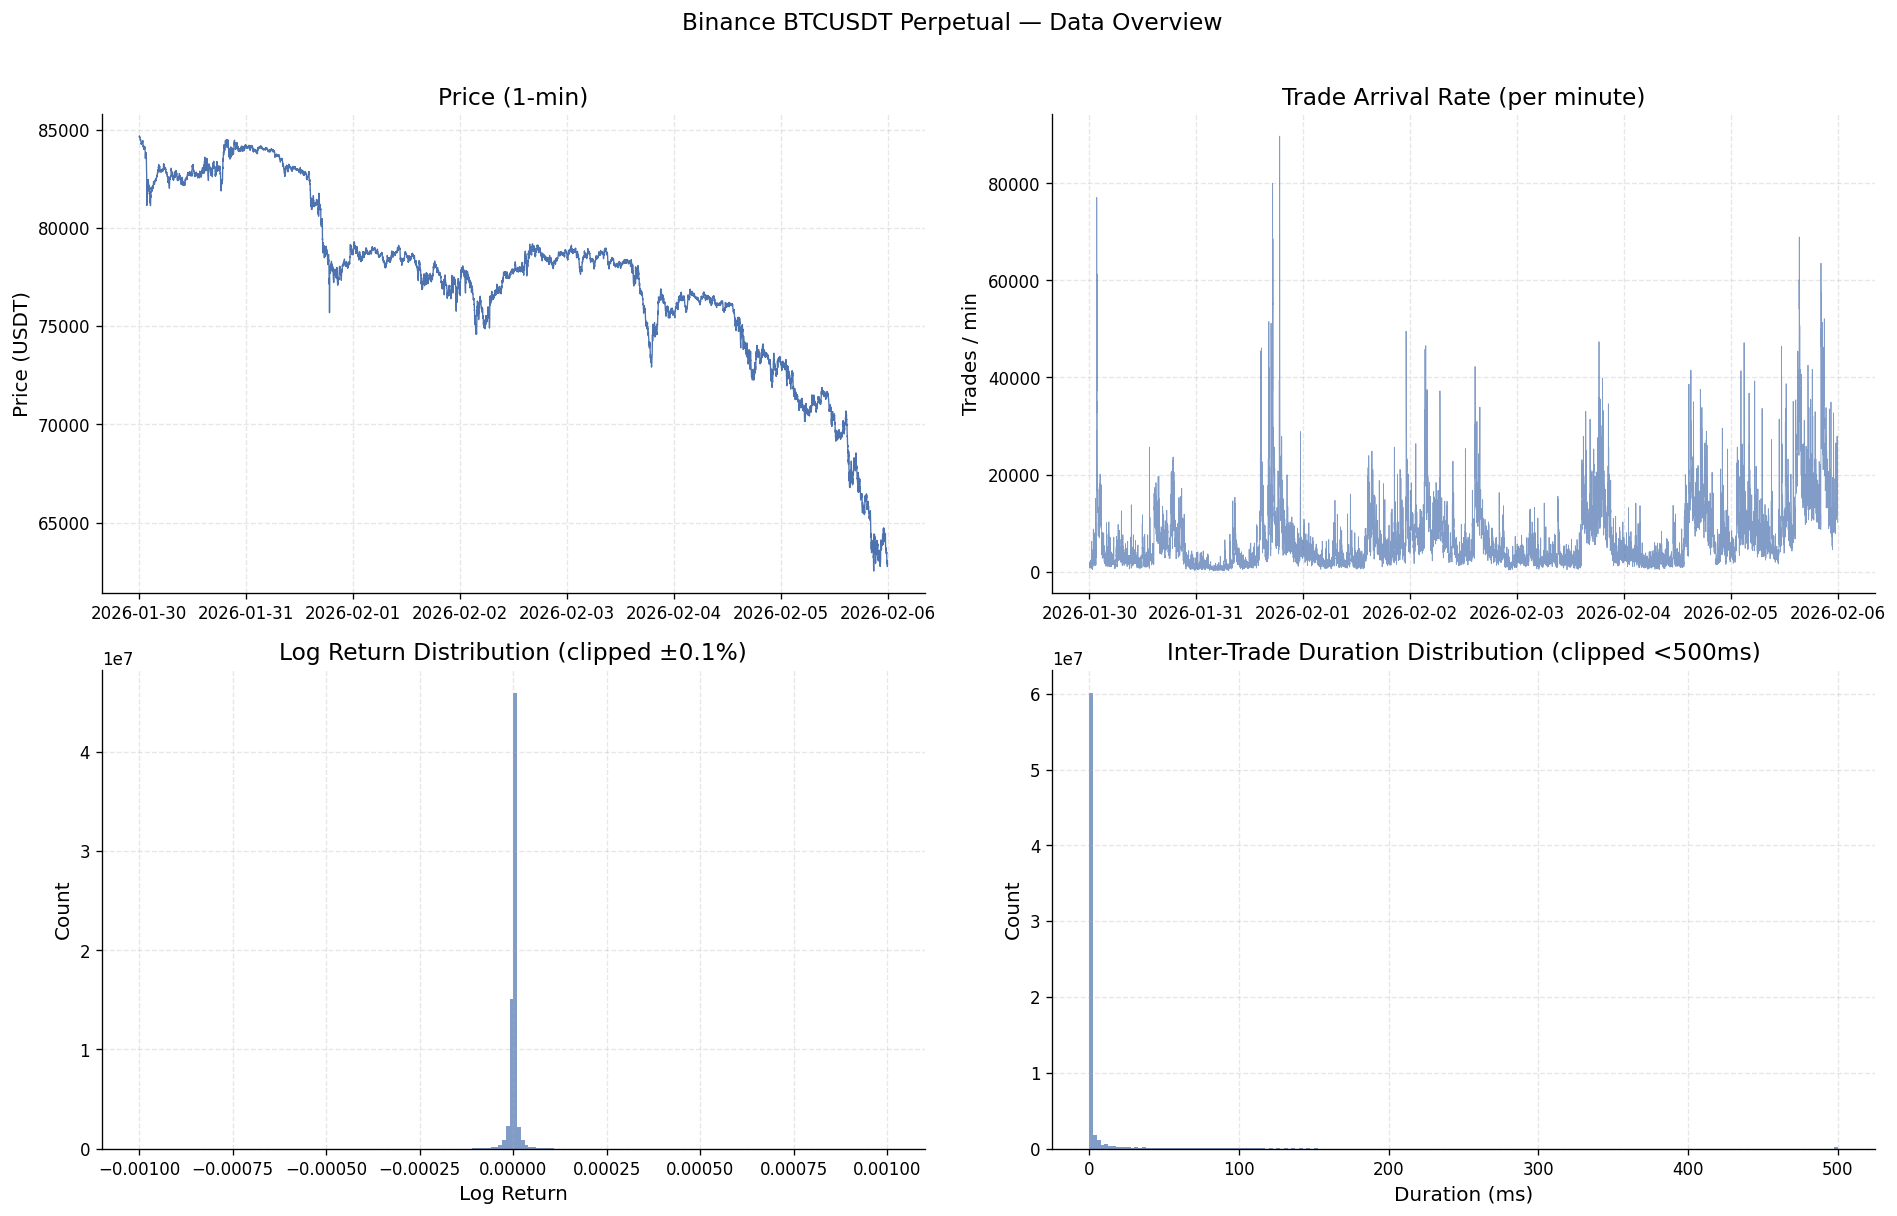

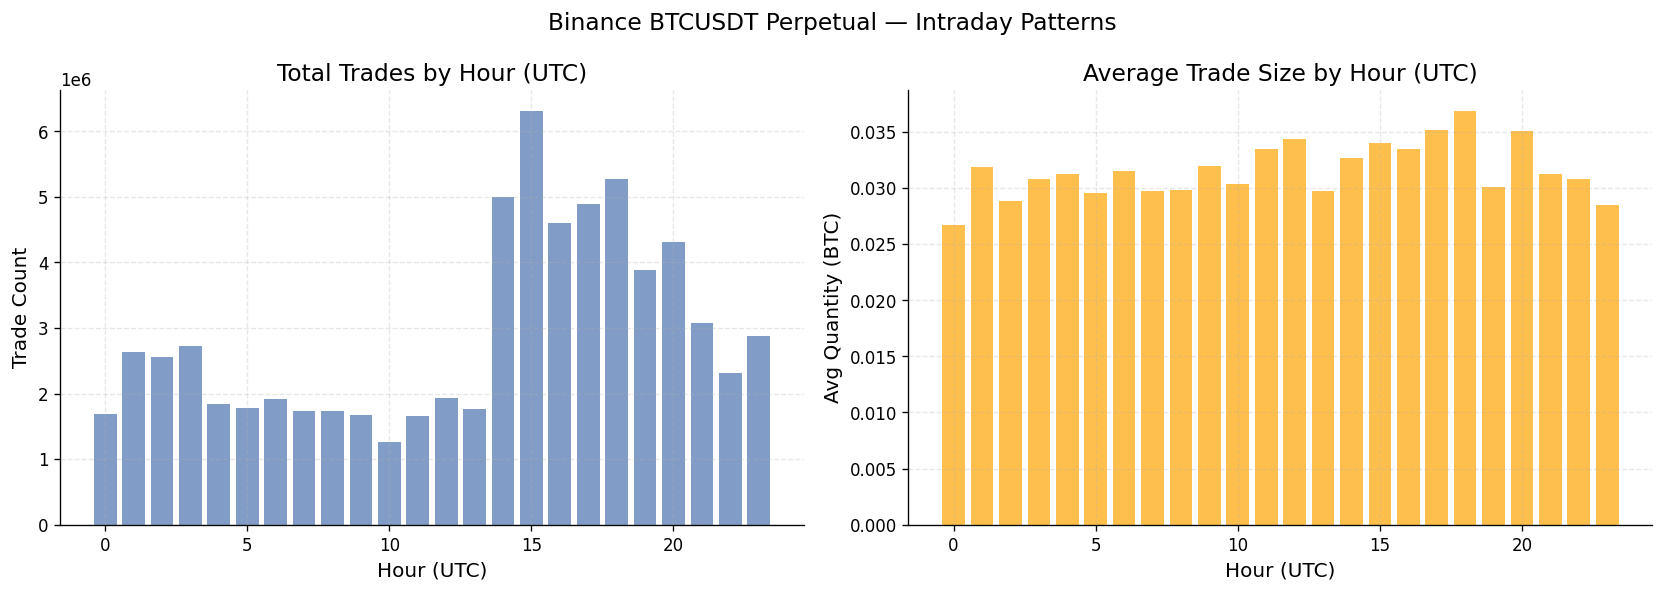

In [3]:
binance_files = download_binance_trades(
    symbol="BTCUSDT",
    start_date=START_DATE,
    end_date=END_DATE,
    output_dir=RAW_BASE / "binance",
)

binance_trades = process_venue(binance_files, venue="binance")
print_quality_report(binance_trades, venue="binance")
plot_venue_overview(binance_trades, "Binance BTCUSDT Perpetual")
plot_intraday(binance_trades, "Binance BTCUSDT Perpetual")

---
## Venue 2: Bybit BTCUSDT Perpetual

Bybit is another major perpetual futures exchange. Daily trade data is available as gzipped CSVs from their [public data endpoint](https://public.bybit.com/trading/BTCUSDT/). The `side` field directly provides trade direction ("Buy"/"Sell").

Downloaded 7 / 7 daily files.


Loaded 35,045,409 raw trades across 7 days.


Time range: 2026-01-30 00:00:00.037100077+00:00 → 2026-02-05 23:59:59.920599937+00:00


Buy-initiated:    17,462,672 (49.8%)
Sell-initiated:   17,582,737 (50.2%)


Log returns — mean: -8.47e-09, std: 2.31e-05


Inter-trade duration — median: 0.0 ms, mean: 17.3 ms


DATA QUALITY REPORT — BYBIT
  venue................................... bybit
  total_trades............................ 35045409
  date_range_start........................ 2026-01-30 00:00:00.037100077+00:00
  date_range_end.......................... 2026-02-05 23:59:59.920599937+00:00
  null_prices............................. 0
  null_quantities......................... 0
  null_trade_signs........................ 0
  unique_dates............................ 7
  gaps_over_1min.......................... 0
  max_gap_seconds......................... 16.949300051
  price_min............................... 62250.0
  price_max............................... 84692.3
  price_mean.............................. 74765.5833595693
  buy_fraction............................ 0.498287008149912
  sell_fraction........................... 0.501712991850088


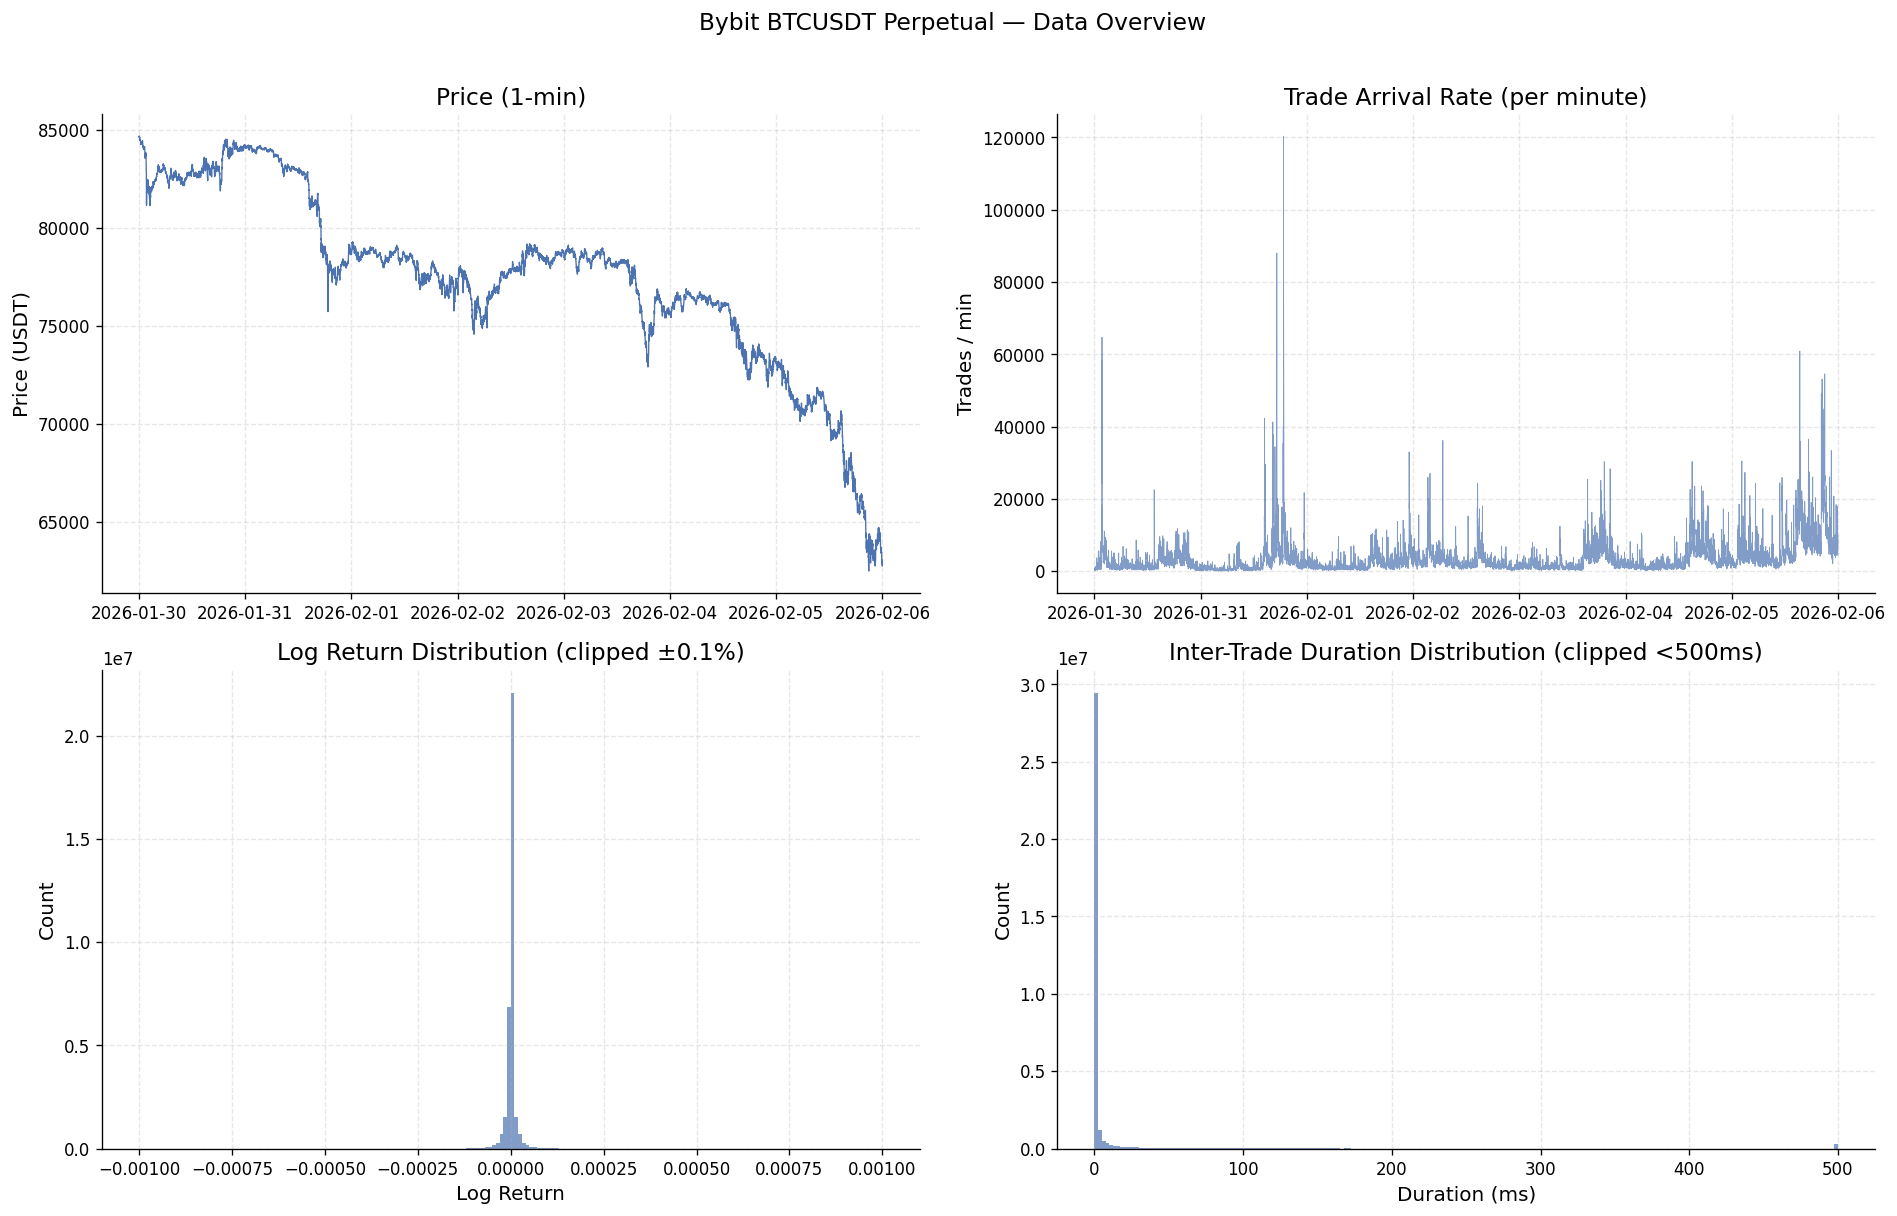

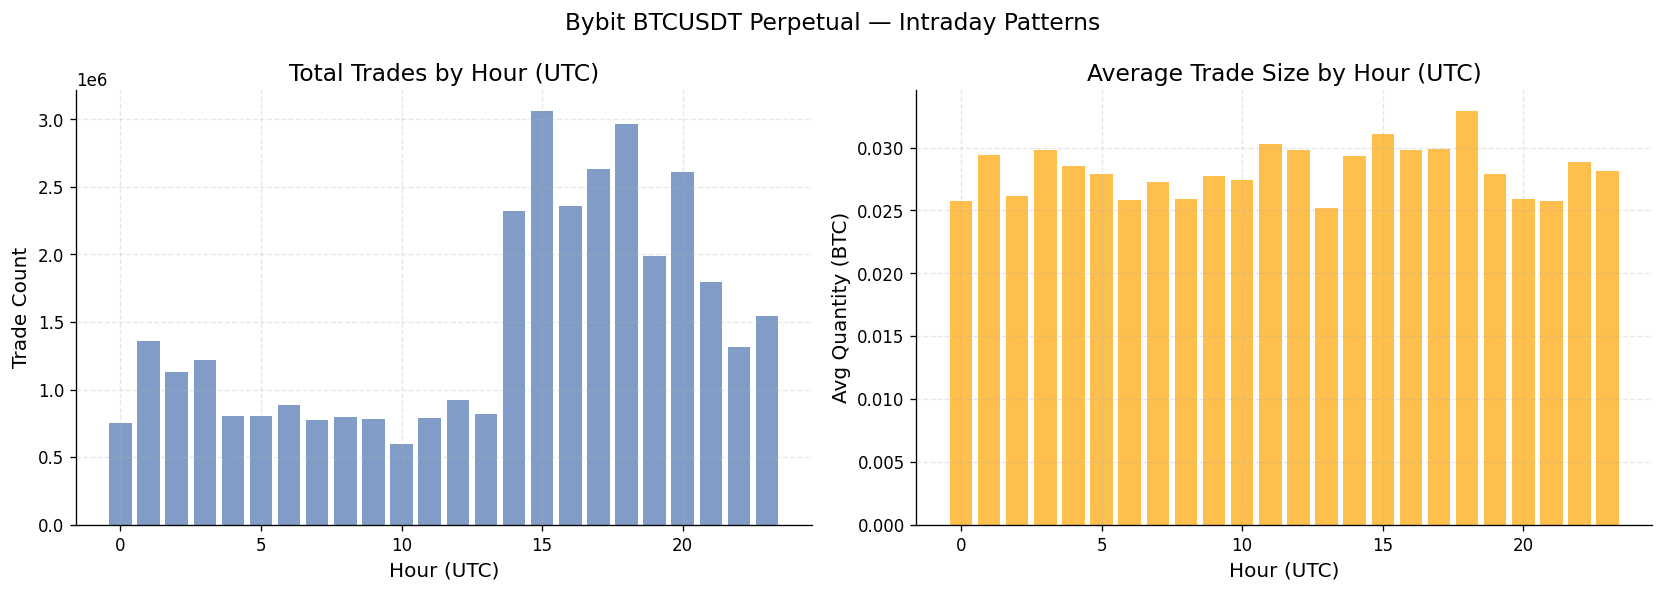

In [4]:
bybit_files = download_bybit_trades(
    symbol="BTCUSDT",
    start_date=START_DATE,
    end_date=END_DATE,
    output_dir=RAW_BASE / "bybit",
)

bybit_trades = process_venue(bybit_files, venue="bybit")
print_quality_report(bybit_trades, venue="bybit")
plot_venue_overview(bybit_trades, "Bybit BTCUSDT Perpetual")
plot_intraday(bybit_trades, "Bybit BTCUSDT Perpetual")

---
## Cross-Venue Comparison

Now that both venues are processed, we compare them side-by-side. This helps validate data quality and reveals structural differences between venues.

Both Binance and Bybit are BTCUSDT **perpetual futures** — comparing them is apples-to-apples and will form the core of our transfer entropy analysis.

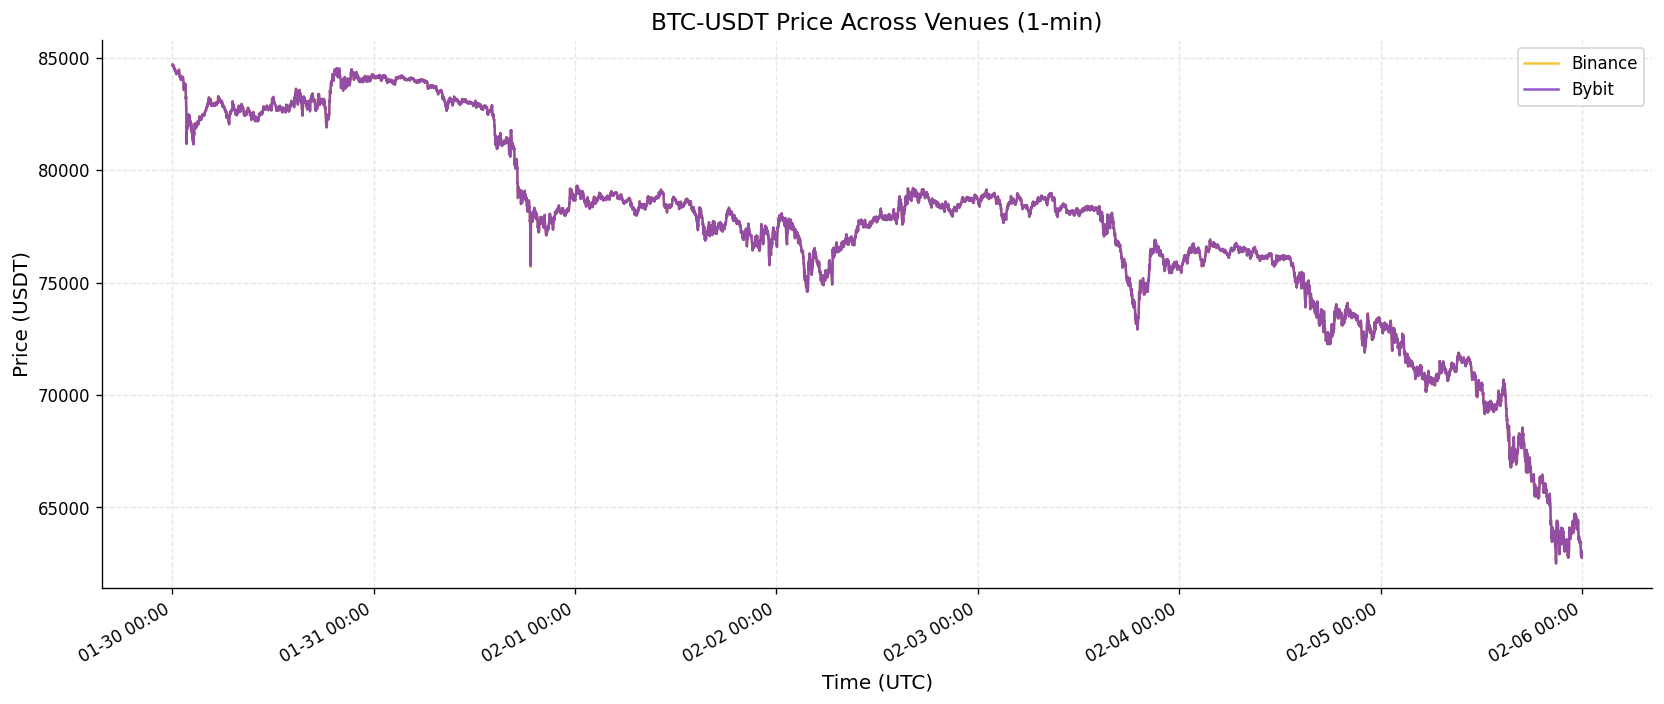

In [5]:
# Price overlay — both venues on the same axes
all_venues = {"binance": binance_trades, "bybit": bybit_trades}

fig = plot_price_overlay(all_venues, title="BTC-USDT Price Across Venues (1-min)")
plt.show()

Absolute price difference stats:
  Mean:   $5.35
  Median: $4.50
  Max:    $54.20
  Std:    $4.19


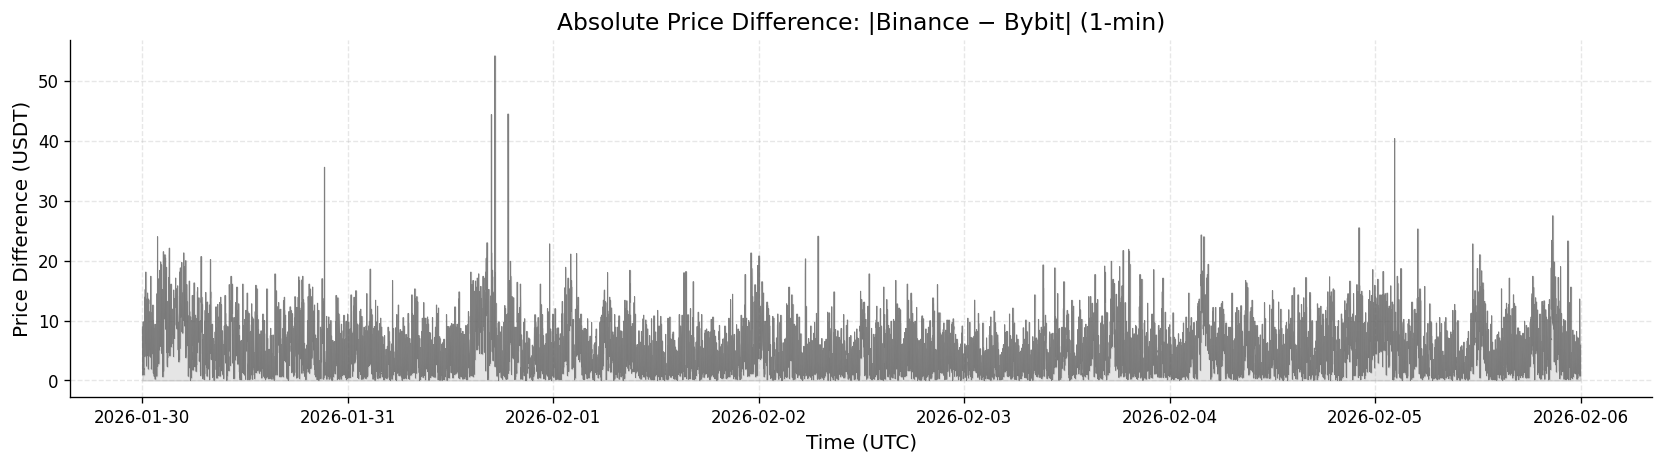

In [6]:
# Absolute price difference between Binance and Bybit (1-min resolution)
binance_price_1m = binance_trades.set_index("timestamp")["price"].resample("1min").last().dropna()
bybit_price_1m = bybit_trades.set_index("timestamp")["price"].resample("1min").last().dropna()

# Align on common timestamps
common_idx = binance_price_1m.index.intersection(bybit_price_1m.index)
abs_diff = (binance_price_1m.loc[common_idx] - bybit_price_1m.loc[common_idx]).abs()

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(abs_diff.index, abs_diff.values, linewidth=0.6, color="#555555", alpha=0.7)
ax.fill_between(abs_diff.index, 0, abs_diff.values, alpha=0.15, color="#555555")
ax.set_title("Absolute Price Difference: |Binance − Bybit| (1-min)")
ax.set_ylabel("Price Difference (USDT)")
ax.set_xlabel("Time (UTC)")
ax.grid(True, alpha=0.3)

# Summary stats
print(f"Absolute price difference stats:")
print(f"  Mean:   ${abs_diff.mean():.2f}")
print(f"  Median: ${abs_diff.median():.2f}")
print(f"  Max:    ${abs_diff.max():.2f}")
print(f"  Std:    ${abs_diff.std():.2f}")

fig.tight_layout()
plt.show()

In [7]:
# Cross-venue statistics comparison table
comparison_rows = []
for venue, trades in all_venues.items():
    buys = (trades["trade_sign"] == 1).sum()
    comparison_rows.append({
        "Venue": venue.capitalize(),
        "Total Trades": f"{len(trades):,}",
        "Avg Trade Size (BTC)": f"{trades['quantity'].mean():.4f}",
        "Buy Fraction": f"{buys / len(trades):.1%}",
        "Mean Inter-Trade (ms)": f"{trades['inter_trade_duration_ms'].mean():.1f}",
        "Price Min": f"${trades['price'].min():,.0f}",
        "Price Max": f"${trades['price'].max():,.0f}",
    })

comparison_df = pd.DataFrame(comparison_rows)
print("Cross-Venue Comparison:")
print(comparison_df.to_string(index=False))

Cross-Venue Comparison:
  Venue Total Trades Avg Trade Size (BTC) Buy Fraction Mean Inter-Trade (ms) Price Min Price Max
Binance   69,445,821               0.0323        49.6%                   8.7   $62,233   $84,697
  Bybit   35,045,409               0.0287        49.8%                  17.3   $62,250   $84,692


---
## Save Processed Data

Save each venue's processed DataFrame to Parquet for efficient loading in subsequent notebooks.

In [8]:
save_processed(binance_trades, PROCESSED_DIR / "binance_btcusdt_perp.parquet")
save_processed(bybit_trades, PROCESSED_DIR / "bybit_btcusdt_perp.parquet")

print("\nAll venues saved successfully.")

Saved 69,445,821 trades to ../data/processed/binance_btcusdt_perp.parquet


Saved 35,045,409 trades to ../data/processed/bybit_btcusdt_perp.parquet

All venues saved successfully.


---
## Summary

**What we have:** 7 days of BTCUSDT perpetual futures trade data from two major venues:

| Venue | Instrument | Trades | Source |
|-------|-----------|--------|--------|
| Binance | BTCUSDT Perp | ~69M | Bulk CSV download |
| Bybit | BTCUSDT Perp | TBD | Bulk gzipped CSV download |

Each trade is tagged with: price, quantity, UTC timestamp (ms precision), trade sign (+1/-1), log return, and inter-trade duration.

**Next:** Notebook 02 — Exploratory Microstructure Analysis (trade sign ACF, cross-venue correlations, venue characteristics).